In [1]:

# # FMA Music Genre Prediction with PCA Playlist Generation
# 
# This notebook modifies the original CNN BatchNorm code to:
# 1. Work with the FMA small dataset for music genre prediction
# 2. Extract features from the second-to-last layer for PCA analysis
# 3. Generate playlists by creating lines between tracks in PCA space

In [2]:


# Install required packages
get_ipython().system('pip install kagglehub pandas scikit-learn matplotlib seaborn plotly')
get_ipython().system('pip install torch torchaudio librosa')

In [3]:


import torch
import torchaudio
import os
import shutil
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
import kagglehub


# ## 1. Load FMA Small Dataset

In [4]:


# Localisation des fichiers
tracks_file =  "../fma_metadata/tracks.csv"
genres_file = "../fma_metadata/genres.csv"

# Chargement des mÃ©tadonnÃ©es
tracks = pd.read_csv(tracks_file, index_col=0, header=[0, 1])
genres_df = pd.read_csv(genres_file)
subset = tracks[tracks[('set', 'subset')] == 'small']

print(f"âœ“ {len(subset)} tracks dans le subset 'small'")

# CrÃ©ation du genre mapping
unique_genres = subset[('track', 'genre_top')].dropna().unique()
genre_mapping = {genre: idx for idx, genre in enumerate(unique_genres)}
reverse_genre_mapping = {idx: genre for genre, idx in genre_mapping.items()}

print(f"âœ“ {len(genre_mapping)} genres : {list(genre_mapping.keys())}")


# ## 2. Modified CNN Architecture for FMA Dataset

âœ“ 8000 tracks dans le subset 'small'
âœ“ 8 genres : ['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International', 'Electronic', 'Instrumental']


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, activations

def residual_block(x, filters, kernel_size=3, stride=1):
    """
    Residual block with two conv layers and skip connection
    """
    shortcut = x

    # First conv
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)

    # Second conv
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)

    # Adjust shortcut if needed
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def FMA_CNN(input_shape=(128, 128, 1), num_genres=8):
    """
    Residual CNN adapted for FMA Small
    """
    inputs = layers.Input(shape=input_shape)

    # Initial conv
    x = layers.Conv2D(32, 5, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = residual_block(x, 256)
    x = layers.MaxPooling2D(2)(x)

    # Global pooling (mean + max over frequency axis) via Lambda layers
    mean_pool = layers.Lambda(lambda t: tf.reduce_mean(t, axis=1))(x)
    max_pool = layers.Lambda(lambda t: tf.reduce_max(t, axis=1))(x)
    x = layers.Concatenate(axis=-1)([mean_pool, max_pool])
    x = layers.Flatten()(x)

    # Fully connected layers
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    features = layers.Dense(256)(x)   # feature layer
    features = layers.BatchNormalization()(features)
    features = layers.Activation('relu')(features)
    x = layers.Dropout(0.5)(features)

    outputs = layers.Dense(num_genres, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="FMA_CNN_Residual")
    feature_model = models.Model(inputs=inputs, outputs=features, name="FMA_Feature_Model")

    return model, feature_model

num_genres = len(genre_mapping)
model, feature_model = FMA_CNN(input_shape=(128, 646, 1), num_genres=8)
model.summary()


Model: "FMA_CNN_Residual"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 646,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 646,  │        832 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 646,  │        128 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_36       │ (None, 128, 646,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 323,   │          0 │ activation_36[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 323,   │        128 │ max_pooling2d_12… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 64, 323,   │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 64, 323,   │     18,496 │ activation_37[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 323,   │        256 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 64, 323,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 323,   │      2,112 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 323,   │     36,928 │ activation_38[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 323,   │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 64, 323,   │          0 │ conv2d_32[0][0],  │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 64, 323,   │          0 │ add_9[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 161,   │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 161,   │        256 │ max_pooling2d_13

 Total params: 11,833,736 (45.14 MB)

 Trainable params: 11,829,896 (45.13 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [6]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from pydub import AudioSegment
import librosa

# --- Paramètres ---
SR = 22050
N_FFT = 2048
HOP_LENGTH = 1024
N_MELS = 128
DURATION = 30.0  # secondes
EXPECTED_FRAMES = int(np.ceil(DURATION * SR / HOP_LENGTH))  # ≈ 646 frames

spectrograms = []
labels = []
track_ids = []
failed_files = 0

def load_audio(filepath, sr=SR, duration=DURATION):
    """
    Load audio using pydub + ffmpeg, convert to mono, resample, and truncate/pad to duration
    """
    audio = AudioSegment.from_file(filepath)
    audio = audio.set_channels(1).set_frame_rate(sr)
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)
    samples /= np.iinfo(audio.array_type).max  # normalize [-1,1]
    
    max_len = int(duration * sr)
    if len(samples) > max_len:
        samples = samples[:max_len]
    elif len(samples) < max_len:
        samples = np.pad(samples, (0, max_len - len(samples)))
    
    return samples

# --- Extraction ---
for track_id, row in tqdm(subset.iterrows(), total=len(subset), desc="Extraction des spectrogrammes"):
    genre_id = row[('track', 'genre_top')]
    if pd.isna(genre_id):
        continue

    folder = f"{track_id // 1000:03d}"
    filepath = os.path.join("../fma_small", folder, f"{track_id:06d}.mp3")

    if not os.path.exists(filepath):
        print(f"⚠️ Fichier introuvable : {filepath}")
        failed_files += 1
        continue

    try:
        # Chargement audio avec pydub
        y = load_audio(filepath, sr=SR, duration=DURATION)

        # Calcul du log-mel spectrogramme
        mel = librosa.feature.melspectrogram(
            y=y,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            power=2.0
        )
        log_mel = librosa.power_to_db(mel, ref=np.max)

        # Ajustement taille temporelle à EXPECTED_FRAMES
        n_frames = log_mel.shape[1]
        if n_frames < EXPECTED_FRAMES:
            log_mel = np.pad(log_mel, ((0, 0), (0, EXPECTED_FRAMES - n_frames)), mode='constant')
        elif n_frames > EXPECTED_FRAMES:
            log_mel = log_mel[:, :EXPECTED_FRAMES]

        # Ajouter un canal pour TensorFlow (hauteur, largeur, channels)
        log_mel = np.expand_dims(log_mel, axis=-1)

        spectrograms.append(log_mel)
        labels.append(genre_mapping[genre_id])
        track_ids.append(f"{track_id:06d}")

    except Exception as e:
        print(f"❌ Erreur avec {filepath}: {e}")
        failed_files += 1
        continue

# --- Conversion en tenseurs TensorFlow ---
spectrograms = tf.convert_to_tensor(np.array(spectrograms), dtype=tf.float32)
labels = tf.convert_to_tensor(np.array(labels), dtype=tf.int32)

print(f"\n✅ Extraction terminée : {spectrograms.shape[0]} spectrogrammes valides.")
print(f"⚠️ Fichiers échoués : {failed_files}")



Extraction des spectrogrammes:  56%|█████▌    | 4472/8000 [11:49<08:24,  6.99it/s]

❌ Erreur avec ../fma_small/099/099134.mp3: Decoding failed. ffmpeg returned error code: 234

Output from ffmpeg/avlib:

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --ena

Extraction des spectrogrammes:  61%|██████▏   | 4905/8000 [12:58<07:08,  7.23it/s]

❌ Erreur avec ../fma_small/108/108925.mp3: Decoding failed. ffmpeg returned error code: 234

Output from ffmpeg/avlib:

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --ena

Extraction des spectrogrammes:  87%|████████▋ | 6967/8000 [18:26<02:31,  6.82it/s]

❌ Erreur avec ../fma_small/133/133297.mp3: Decoding failed. ffmpeg returned error code: 234

Output from ffmpeg/avlib:

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --ena

Extraction des spectrogrammes: 100%|██████████| 8000/8000 [21:14<00:00,  6.28it/s]



✅ Extraction terminée : 7997 spectrogrammes valides.
⚠️ Fichiers échoués : 3


2025-10-14 20:25:39.866499: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 2645023744 exceeds 10% of free system memory.


In [7]:
import tensorflow as tf
import random
import numpy as np

print(f"Created {len(spectrograms)} samples")
print(f"Spectrogram shape: {spectrograms[0].shape}")
print(f"Genre mapping: {genre_mapping}")

def split_fma_dataset_tf(spectrograms, labels, track_ids, train_ratio=0.7, val_ratio=0.15):
    """
    Split FMA dataset into train/validation/test sets (TensorFlow version)
    """
    n_samples = spectrograms.shape[0]
    indices = list(range(n_samples))
    random.shuffle(indices)

    train_end = int(train_ratio * n_samples)
    val_end = int((train_ratio + val_ratio) * n_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Split arrays
    train_specs = tf.gather(spectrograms, train_indices)
    train_labels = tf.gather(labels, train_indices)
    train_ids = [track_ids[i] for i in train_indices]

    val_specs = tf.gather(spectrograms, val_indices)
    val_labels = tf.gather(labels, val_indices)
    val_ids = [track_ids[i] for i in val_indices]

    test_specs = tf.gather(spectrograms, test_indices)
    test_labels = tf.gather(labels, test_indices)
    test_ids = [track_ids[i] for i in test_indices]

    return (train_specs, train_labels, train_ids), (val_specs, val_labels, val_ids), (test_specs, test_labels, test_ids)

# Split dataset
train_data, val_data, test_data = split_fma_dataset_tf(spectrograms, labels, track_ids)

print(f"Train set: {train_data[0].shape[0]} samples")
print(f"Validation set: {val_data[0].shape[0]} samples")
print(f"Test set: {test_data[0].shape[0]} samples")

# Créer les tf.data.Dataset
batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_data[0], train_data[1]))
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_data[0], val_data[1]))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data[0], test_data[1]))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)



# ## 4. Training the Model

2025-10-14 20:25:52.003528: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1851218944 exceeds 10% of free system memory.


Created 7997 samples
Spectrogram shape: (128, 646, 1)
Genre mapping: {'Hip-Hop': 0, 'Pop': 1, 'Folk': 2, 'Experimental': 3, 'Rock': 4, 'International': 5, 'Electronic': 6, 'Instrumental': 7}
Train set: 5597 samples
Validation set: 1200 samples
Test set: 1200 samples


2025-10-14 20:25:52.272144: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 396902400 exceeds 10% of free system memory.
2025-10-14 20:25:52.321504: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 396902400 exceeds 10% of free system memory.


In [12]:
import tensorflow as tf
from tensorflow.keras import callbacks, optimizers, losses, metrics
import numpy as np

# --- Définir le scheduler cosine annealing ---
def cosine_decay_schedule(epoch, lr):
    max_epochs = 20
    min_lr = 1e-6
    max_lr = 0.001
    return min_lr + (max_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * epoch / max_epochs))

# --- Callbacks ---
checkpoint_cb = callbacks.ModelCheckpoint(
    'best_fma_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

cosine_lr_cb = callbacks.LearningRateScheduler(cosine_decay_schedule, verbose=1)

# Compiler le modèle
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# --- Entraîner le modèle ---
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb, cosine_lr_cb],
    verbose=1
)

# --- Historique des métriques ---
train_losses = history.history['loss']
val_losses = history.history['val_loss']
train_accs = history.history['accuracy']
val_accs = history.history['val_accuracy']

print(f"Training completed. Best validation accuracy: {max(val_accs)*100:.2f}%")



# ## 5. Feature Extraction for PCA Analysis


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3053 - loss: 2.0901
Epoch 1: val_accuracy improved from None to 0.28500, saving model to best_fma_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 952s 5s/step - accuracy: 0.3513 - loss: 1.9279 - val_accuracy: 0.2850 - val_loss: 2.5683 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009938503261272714.
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4237 - loss: 1.6494
Epoch 2: val_accuracy did not improve from 0.28500
175/175 ━━━━━━━━━━━━━━━━━━━━ 919s 5s/step - accuracy: 0.4417 - loss: 1.5976 - val_accuracy: 0.2708 - val_loss: 2.5388 - learning_rate: 9.9385e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009755527298894294.
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4813 - loss: 1.5079
Epoch 3: val_accuracy improved from 0.28500 to 0.29000, saving model to best_fma_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 913s 5s/step - accuracy: 0.4892 - loss: 1.4776 - val_accuracy: 0.2900 - val_loss: 1.9591 - learning_rate: 9.7555e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0009455577588320898.
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5331 - loss: 1.3468
Epoch 4: val_accuracy improved from 0.29000 to 0.47833, saving model to best_fma_model.h5


175/175 ━━━━━━━━━━━━━━━━━━━━ 909s 5s/step - accuracy: 0.5362 - loss: 1.3597 - val_accuracy: 0.4783 - val_loss: 1.5478 - learning_rate: 9.4556e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0009046039886902864.
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5520 - loss: 1.2852
Epoch 5: val_accuracy did not improve from 0.47833
175/175 ━━━━━━━━━━━━━━━━━━━━ 906s 5s/step - accuracy: 0.5590 - loss: 1.2872 - val_accuracy: 0.3500 - val_loss: 2.0357 - learning_rate: 9.0460e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0008536998372026805.
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5764 - loss: 1.2339
Epoch 6: val_accuracy did not improve from 0.47833
175/175 ━━━━━━━━━━━━━━━━━━━━ 915s 5s/step - accuracy: 0.5800 - loss: 1.2246 - val_accuracy: 0.4733 - val_loss: 1.6598 - learning_rate: 8.5370e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0007940987335200904.
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step

KeyboardInterrupt: 

In [13]:
import numpy as np
import tensorflow as tf

def extract_features_from_model_keras(feature_model, dataset):
    """
    Extract features from the feature layer (second-to-last dense layer) for PCA or analysis
    """
    all_features = []
    all_labels = []
    all_predictions = []

    for batch_inputs, batch_labels in dataset:
        # Passer le batch dans le feature_model et le modèle complet
        features = feature_model(batch_inputs, training=False)  # shape: (batch_size, feature_dim)
        outputs = model(batch_inputs, training=False)           # shape: (batch_size, num_genres)
        predictions = tf.argmax(outputs, axis=1)

        all_features.append(features.numpy())
        all_labels.append(batch_labels.numpy())
        all_predictions.append(predictions.numpy())

    # Concatenate all batches
    features_array = np.concatenate(all_features, axis=0)
    labels_array = np.concatenate(all_labels, axis=0)
    predictions_array = np.concatenate(all_predictions, axis=0)

    return features_array, labels_array, predictions_array

# --- Extraction des features du test set ---
print("Extracting features from test set...")
test_features, test_labels_array, test_predictions = extract_features_from_model_keras(
    feature_model, test_dataset
)
print(f"Extracted features shape: {test_features.shape}")
print(f"Feature dimension: {test_features.shape[1]}")

# --- Extraction des features d’un sous-ensemble d’entraînement ---
print("\nExtracting features from training subset...")
train_subset = train_dataset.take(10)  # Exemple : prendre 10 batches pour analyse rapide
train_features, train_labels_array, train_predictions = extract_features_from_model_keras(
    feature_model, train_subset
)
print(f"Training features shape: {train_features.shape}")



# ## 6. PCA Analysis and Visualization

Extracting features from test set...


2025-10-14 22:50:08.946430: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Extracted features shape: (1200, 256)
Feature dimension: 256

Extracting features from training subset...
Training features shape: (320, 256)


2025-10-14 22:50:37.652530: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def perform_pca_analysis_keras(features, labels, n_components=2):
    """
    Perform PCA analysis on features extracted from a Keras model
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features_scaled)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")

    return features_pca, pca, scaler

# --- PCA sur les features du test set ---
print("Performing PCA analysis...")
test_pca_features, pca_model, scaler = perform_pca_analysis_keras(test_features, test_labels_array)

# Créer un DataFrame pour visualisation / manipulation
pca_df = pd.DataFrame({
    'PC1': test_pca_features[:, 0],
    'PC2': test_pca_features[:, 1],
    'genre': test_labels_array,
    'track_id': test_data[2][:len(test_labels_array)]
})

# Ajouter les noms de genres
genre_names = list(genre_mapping.keys())
pca_df['genre_name'] = pca_df['genre'].map(lambda x: genre_names[x])

print(f"PCA DataFrame shape: {pca_df.shape}")
print(pca_df.head())


Performing PCA analysis...
PCA explained variance ratio: [0.23244832 0.16355278]
Total explained variance: 0.396
PCA DataFrame shape: (1200, 5)
         PC1       PC2  genre track_id     genre_name
0  -7.020872  9.423238      5   043698  International
1  10.340714 -4.183471      6   100536     Electronic
2  10.223536 -2.076301      6   011262     Electronic
3   2.715221 -2.115151      4   130683           Rock
4   0.462271  6.149746      2   047506           Folk


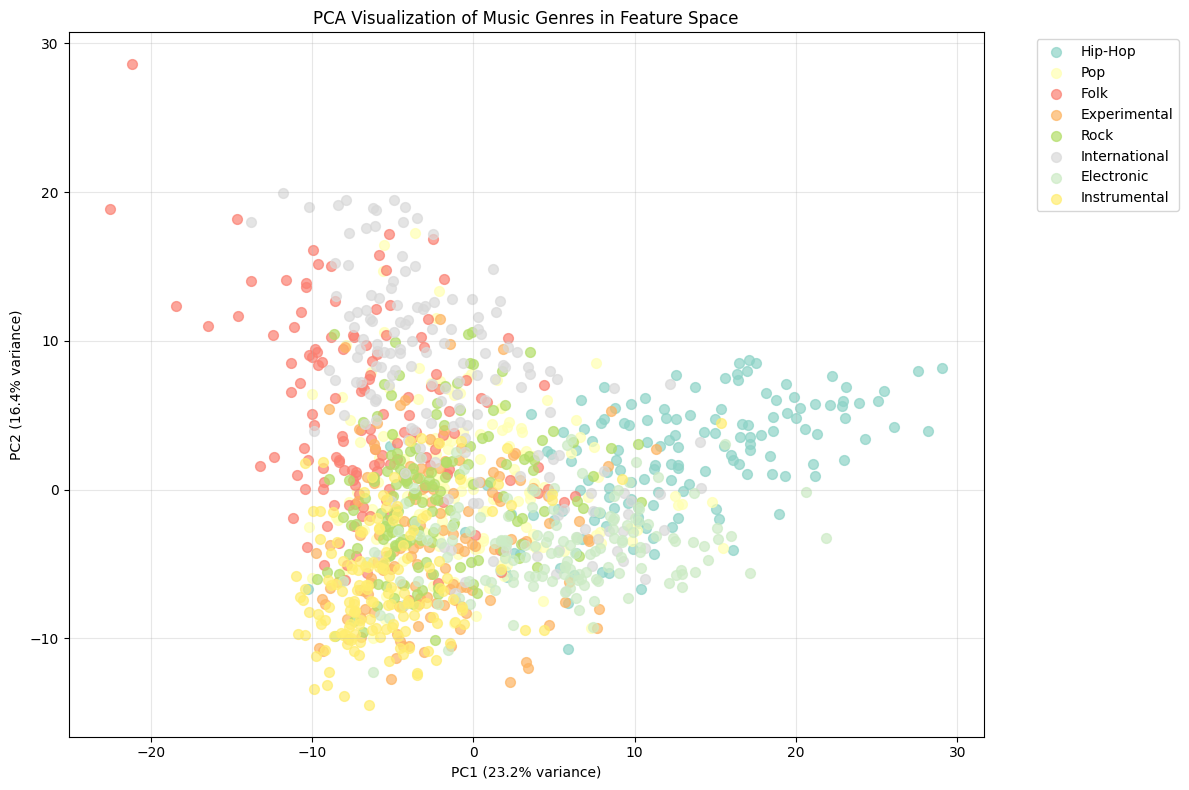

In [15]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

# --- Visualisation statique avec Matplotlib ---
plt.figure(figsize=(12, 8))

colors = plt.cm.Set3(np.linspace(0, 1, len(genre_names)))
for i, genre in enumerate(genre_names):
    mask = pca_df['genre'] == i
    plt.scatter(
        pca_df[mask]['PC1'],
        pca_df[mask]['PC2'],
        c=[colors[i]],
        label=genre,
        alpha=0.7,
        s=50
    )

plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.1%} variance)')
plt.title('PCA Visualization of Music Genres in Feature Space')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Visualisation interactive avec Plotly ---
import plotly.express as px

fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='genre_name',
    hover_data=['track_id'],
    title='Interactive PCA Visualization of Music Genres',
    labels={
        'PC1': f'PC1 ({pca_model.explained_variance_ratio_[0]:.1%})',
        'PC2': f'PC2 ({pca_model.explained_variance_ratio_[1]:.1%})'
    }
)
fig.show()



# ## 7. Playlist Generation Algorithm

In [16]:
import numpy as np
import random

def generate_playlist_line_keras(pca_df, track1_id, track2_id, num_tracks=10):
    """
    Generate a playlist by creating a line between two tracks in PCA space
    and finding tracks closest to points along this line
    """
    # Get coordinates of the two reference tracks
    track1_data = pca_df[pca_df['track_id'] == track1_id]
    track2_data = pca_df[pca_df['track_id'] == track2_id]

    if len(track1_data) == 0 or len(track2_data) == 0:
        print("One or both tracks not found!")
        return None

    # Get PCA coordinates
    p1 = np.array([track1_data['PC1'].iloc[0], track1_data['PC2'].iloc[0]])
    p2 = np.array([track2_data['PC1'].iloc[0], track2_data['PC2'].iloc[0]])

    print(f"Track 1 ({track1_id}): PC1={p1[0]:.3f}, PC2={p1[1]:.3f}")
    print(f"Track 2 ({track2_id}): PC1={p2[0]:.3f}, PC2={p2[1]:.3f}")

    # Generate points along the line
    t_values = np.linspace(0, 1, num_tracks)
    line_points = np.array([p1 + t * (p2 - p1) for t in t_values])

    # Find closest tracks to each point on the line
    playlist_tracks = []
    used_tracks = set()

    for i, target_point in enumerate(line_points):
        # Calculate distances to all tracks
        distances = []
        for idx, row in pca_df.iterrows():
            if row['track_id'] not in used_tracks:
                track_point = np.array([row['PC1'], row['PC2']])
                distance = np.linalg.norm(track_point - target_point)
                distances.append((distance, row['track_id'], row['genre_name'], track_point))

        # Find closest unused track
        if distances:
            distances.sort(key=lambda x: x[0])
            closest_distance, closest_track, closest_genre, closest_point = distances[0]

            playlist_tracks.append({
                'position': i + 1,
                'track_id': closest_track,
                'genre': closest_genre,
                'distance_to_line': closest_distance,
                'target_point': target_point,
                'actual_point': closest_point,
                'PC1': closest_point[0],
                'PC2': closest_point[1]
            })

            used_tracks.add(closest_track)

    return playlist_tracks, line_points, p1, p2

# --- Exemple d'utilisation ---
available_tracks = pca_df['track_id'].tolist()
track1 = random.choice(available_tracks)
track2 = random.choice([t for t in available_tracks if t != track1])

print(f"Generating playlist between {track1} and {track2}...")
playlist, line_points, p1, p2 = generate_playlist_line_keras(pca_df, track1, track2, num_tracks=10)

# Display playlist
if playlist:
    print("\nGenerated Playlist:")
    print("-" * 80)
    for track in playlist:
        print(f"{track['position']:2d}. {track['track_id']} ({track['genre']}) - "
              f"Distance: {track['distance_to_line']:.3f}")

    total_distance = sum(track['distance_to_line'] for track in playlist)
    avg_distance = total_distance / len(playlist)
    print(f"\nPlaylist Quality Metrics:")
    print(f"Average distance to line: {avg_distance:.3f}")
    print(f"Total distance: {total_distance:.3f}")


# ## 8. Playlist Visualization

Generating playlist between 085791 and 027164...
Track 1 (085791): PC1=-1.427, PC2=-1.387
Track 2 (027164): PC1=-2.059, PC2=7.300

Generated Playlist:
--------------------------------------------------------------------------------
 1. 085791 (Rock) - Distance: 0.000
 2. 025797 (International) - Distance: 0.218
 3. 012551 (Pop) - Distance: 0.336
 4. 125189 (Folk) - Distance: 0.169
 5. 085421 (Pop) - Distance: 0.306
 6. 094634 (Pop) - Distance: 0.107
 7. 108290 (Rock) - Distance: 0.084
 8. 000204 (Folk) - Distance: 0.431
 9. 142577 (International) - Distance: 0.384
10. 027164 (Pop) - Distance: 0.000

Playlist Quality Metrics:
Average distance to line: 0.203
Total distance: 2.035


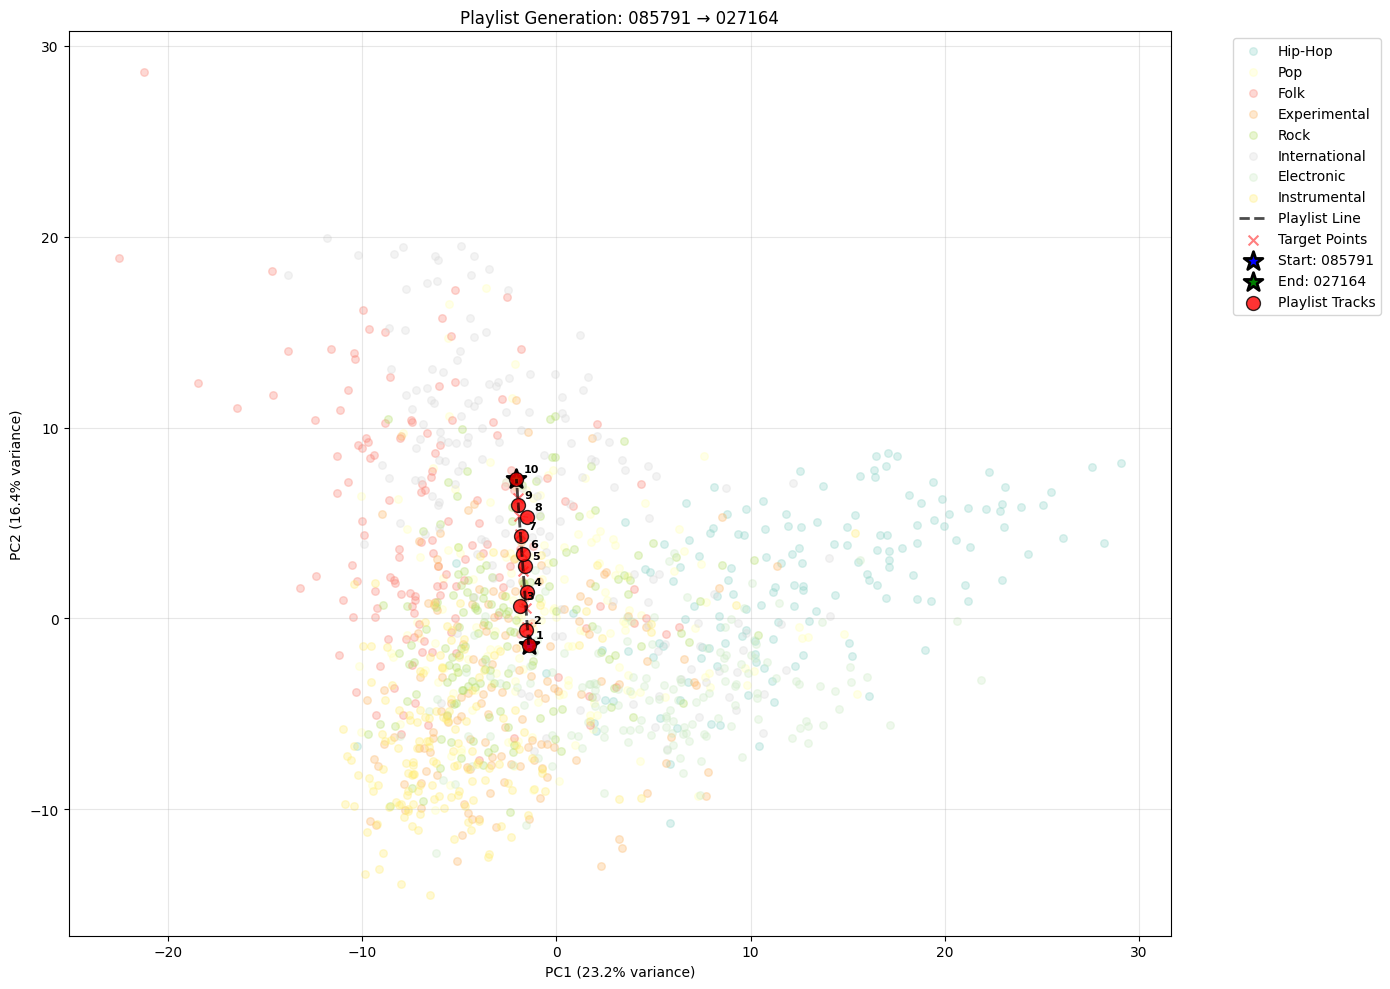

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_playlist_keras(pca_df, playlist, line_points, p1, p2, track1_id, track2_id):
    """
    Visualize the generated playlist on the PCA plot
    """
    plt.figure(figsize=(14, 10))

    # Plot all tracks as background
    colors = plt.cm.Set3(np.linspace(0, 1, len(genre_names)))
    for i, genre in enumerate(genre_names):
        mask = pca_df['genre'] == i
        plt.scatter(
            pca_df[mask]['PC1'], 
            pca_df[mask]['PC2'], 
            c=[colors[i]], 
            label=genre, 
            alpha=0.3, 
            s=30
        )

    # Plot the line between reference tracks
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', linewidth=2, alpha=0.7, label='Playlist Line')

    # Plot line points
    plt.scatter(
        line_points[:, 0], line_points[:, 1], 
        c='red', s=50, alpha=0.5, marker='x', label='Target Points'
    )

    # Plot reference tracks
    plt.scatter([p1[0]], [p1[1]], c='blue', s=200, marker='*', 
                edgecolors='black', linewidth=2, label=f'Start: {track1_id}')
    plt.scatter([p2[0]], [p2[1]], c='green', s=200, marker='*', 
                edgecolors='black', linewidth=2, label=f'End: {track2_id}')

    # Plot playlist tracks
    playlist_points = np.array([[track['PC1'], track['PC2']] for track in playlist])
    plt.scatter(
        playlist_points[:, 0], playlist_points[:, 1], 
        c='red', s=100, alpha=0.8, edgecolors='black', linewidth=1, label='Playlist Tracks'
    )

    # Add track numbers
    for track in playlist:
        plt.annotate(
            str(track['position']), 
            (track['PC1'], track['PC2']), 
            xytext=(5, 5), textcoords='offset points',
            fontsize=8, fontweight='bold'
        )

    # Draw lines from target points to actual tracks
    for track in playlist:
        target = track['target_point']
        actual = track['actual_point']
        plt.plot([target[0], actual[0]], [target[1], actual[1]], 'r-', alpha=0.3, linewidth=1)

    plt.xlabel(f'PC1 ({pca_model.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca_model.explained_variance_ratio_[1]:.1%} variance)')
    plt.title(f'Playlist Generation: {track1_id} → {track2_id}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Visualiser la playlist générée ---
if playlist:
    visualize_playlist_keras(pca_df, playlist, line_points, p1, p2, track1, track2)

# ## 9. Interactive Playlist Generator

In [18]:
import random
import numpy as np

def interactive_playlist_generator_keras(pca_df):
    """
    Interactive function to generate playlists between user-selected tracks
    (Keras-compatible)
    """
    print("Available tracks (first 20 shown):")
    for i, (idx, row) in enumerate(pca_df.head(20).iterrows()):
        print(f"{i+1:2d}. {row['track_id']} ({row['genre_name']})")

    print("\nExample usage:")
    print("track1 = pca_df.iloc[0]['track_id']  # First track")
    print("track2 = pca_df.iloc[10]['track_id']  # Eleventh track")
    print("playlist, line_points, p1, p2 = generate_playlist_line_keras(pca_df, track1, track2, num_tracks=8)")
    print("visualize_playlist_keras(pca_df, playlist, line_points, p1, p2, track1, track2)")

# --- Call the interactive generator ---
interactive_playlist_generator_keras(pca_df)

# --- Generate a few example playlists ---
print("\n" + "="*80)
print("GENERATING ADDITIONAL EXAMPLE PLAYLISTS")
print("="*80)

for i in range(3):
    print(f"\n--- Example Playlist {i+1} ---")

    # Select tracks from different genres
    available_tracks = pca_df['track_id'].tolist()
    track1 = random.choice(available_tracks)
    track2 = random.choice([t for t in available_tracks if t != track1])

    playlist, line_points, p1, p2 = generate_playlist_line_keras(pca_df, track1, track2, num_tracks=8)

    if playlist:
        print(f"Playlist from {track1} to {track2}:")
        for track in playlist:
            print(f"  {track['position']}. {track['track_id']} ({track['genre']})")

        avg_distance = sum(track['distance_to_line'] for track in playlist) / len(playlist)
        print(f"  Average distance to line: {avg_distance:.3f}")


# ## 10. Advanced Analysis and Metrics

Available tracks (first 20 shown):
 1. 043698 (International)
 2. 100536 (Electronic)
 3. 011262 (Electronic)
 4. 130683 (Rock)
 5. 047506 (Folk)
 6. 093921 (Instrumental)
 7. 067366 (Pop)
 8. 099364 (International)
 9. 122473 (Pop)
10. 148537 (Rock)
11. 107909 (Electronic)
12. 045515 (Folk)
13. 021860 (Rock)
14. 148210 (Folk)
15. 054476 (International)
16. 038910 (Experimental)
17. 098580 (Hip-Hop)
18. 119026 (Experimental)
19. 116489 (Instrumental)
20. 133450 (Instrumental)

Example usage:
track1 = pca_df.iloc[0]['track_id']  # First track
track2 = pca_df.iloc[10]['track_id']  # Eleventh track
playlist, line_points, p1, p2 = generate_playlist_line_keras(pca_df, track1, track2, num_tracks=8)
visualize_playlist_keras(pca_df, playlist, line_points, p1, p2, track1, track2)

GENERATING ADDITIONAL EXAMPLE PLAYLISTS

--- Example Playlist 1 ---
Track 1 (110688): PC1=3.191, PC2=-3.702
Track 2 (110610): PC1=4.689, PC2=-9.131
Playlist from 110688 to 110610:
  1. 110688 (Electronic)
  2. 045149 

PLAYLIST QUALITY ANALYSIS
Number of tracks: 8
Unique genres: 5
Genre diversity ratio: 0.62
Average distance to line: 0.241
Standard deviation of distances: 0.201
Maximum distance to line: 0.536
Average smoothness: 0.813

Genre distribution:
  Rock: 2 tracks
  Instrumental: 2 tracks
  Experimental: 2 tracks
  Pop: 1 tracks
  International: 1 tracks


NameError: name 'train_losses' is not defined

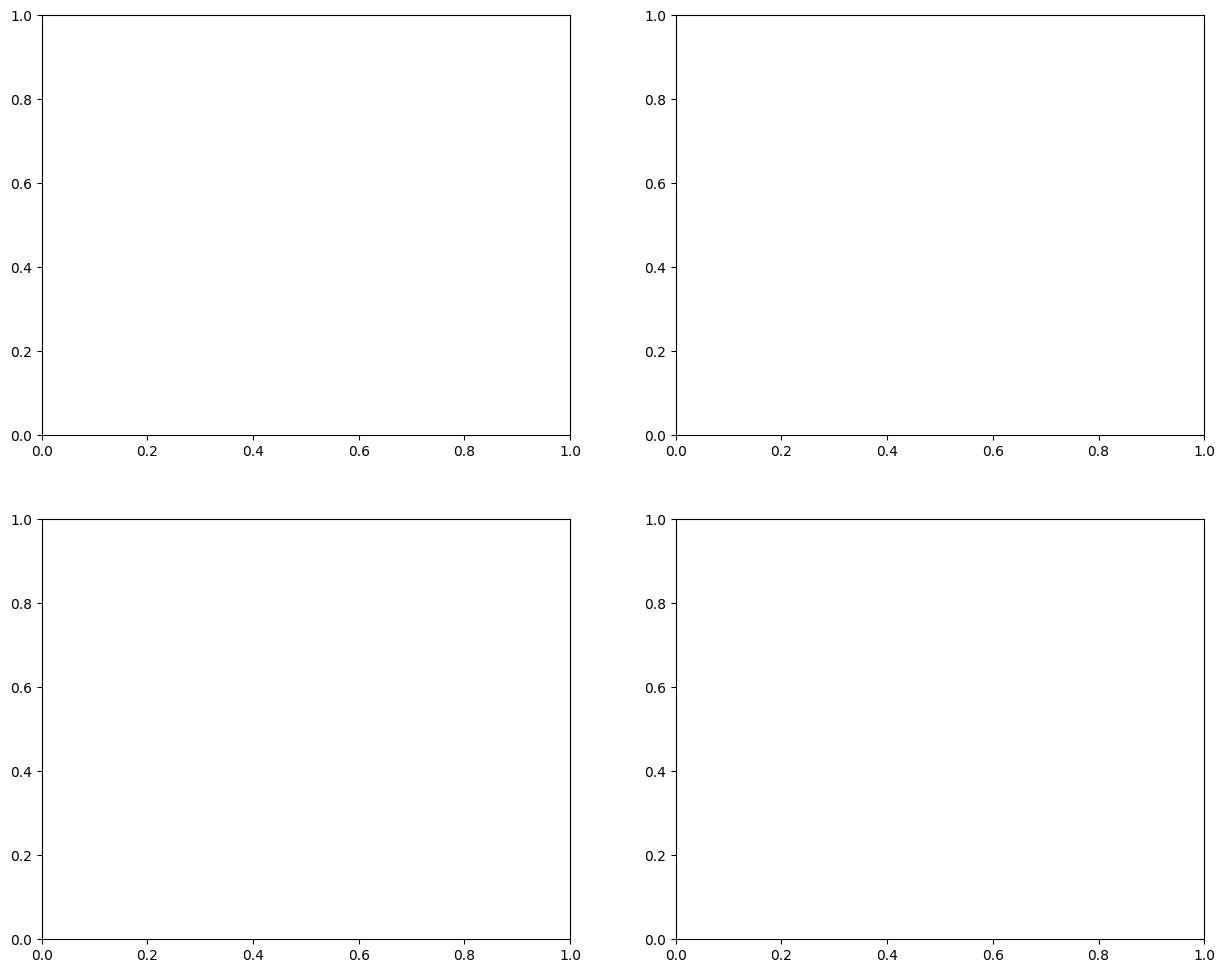

In [19]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_playlist_quality_keras(playlist, pca_df):
    """
    Analyze the quality and characteristics of a generated playlist
    (Keras-compatible)
    """
    if not playlist:
        return None

    # Genre diversity
    genres_in_playlist = [track['genre'] for track in playlist]
    unique_genres = len(set(genres_in_playlist))
    genre_distribution = pd.Series(genres_in_playlist).value_counts()

    # Distance metrics
    distances = [track['distance_to_line'] for track in playlist]
    avg_distance = np.mean(distances)
    std_distance = np.std(distances)
    max_distance = np.max(distances)

    # Smoothness (distance between consecutive tracks)
    smoothness_distances = []
    for i in range(len(playlist) - 1):
        p1 = np.array([playlist[i]['PC1'], playlist[i]['PC2']])
        p2 = np.array([playlist[i+1]['PC1'], playlist[i+1]['PC2']])
        smoothness_distances.append(np.linalg.norm(p2 - p1))

    avg_smoothness = np.mean(smoothness_distances) if smoothness_distances else 0

    analysis = {
        'num_tracks': len(playlist),
        'unique_genres': unique_genres,
        'genre_diversity_ratio': unique_genres / len(playlist),
        'avg_distance_to_line': avg_distance,
        'std_distance_to_line': std_distance,
        'max_distance_to_line': max_distance,
        'avg_smoothness': avg_smoothness,
        'genre_distribution': genre_distribution.to_dict()
    }

    return analysis


# --- Analyse de la dernière playlist générée ---
if playlist:
    analysis = analyze_playlist_quality_keras(playlist, pca_df)

    print("PLAYLIST QUALITY ANALYSIS")
    print("="*40)
    print(f"Number of tracks: {analysis['num_tracks']}")
    print(f"Unique genres: {analysis['unique_genres']}")
    print(f"Genre diversity ratio: {analysis['genre_diversity_ratio']:.2f}")
    print(f"Average distance to line: {analysis['avg_distance_to_line']:.3f}")
    print(f"Standard deviation of distances: {analysis['std_distance_to_line']:.3f}")
    print(f"Maximum distance to line: {analysis['max_distance_to_line']:.3f}")
    print(f"Average smoothness: {analysis['avg_smoothness']:.3f}")
    print("\nGenre distribution:")
    for genre, count in analysis['genre_distribution'].items():
        genre_name = genre_names[genre] if isinstance(genre, int) else genre
        print(f"  {genre_name}: {count} tracks")


# --- Visualisation récapitulative ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training history
axes[0, 0].plot(train_losses, label='Train Loss', color='blue')
axes[0, 0].plot(val_losses, label='Val Loss', color='red')
axes[0, 0].set_title('Training History - Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(train_accs, label='Train Accuracy', color='blue')
axes[0, 1].plot(val_accs, label='Val Accuracy', color='red')
axes[0, 1].set_title('Training History - Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# PCA explained variance
pca_components = range(1, len(pca_model.explained_variance_ratio_) + 1)
axes[1, 0].bar(pca_components, pca_model.explained_variance_ratio_)
axes[1, 0].set_title('PCA Explained Variance Ratio')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Explained Variance Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Genre distribution dans le dataset
genre_counts = pca_df['genre_name'].value_counts()
axes[1, 1].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%')
axes[1, 1].set_title('Genre Distribution in Test Set')

plt.tight_layout()
plt.show()
